# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load FBM stroma lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
EI macrophage                 92
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     13

In [7]:
stromal_celltypes = ['adipo-CAR', 'arteriolar fibroblast', 'tip EC', 'stromal macrophage', 'sinusoidal EC', 
                      'schwann cells', 'proliferating EC', 'osteoclast', 'osteochondral precursor', 
                      'osteoblast precursor',                                        
                     'osteoblast', 'myofibroblast', 'muscle stem cell', 'muscle', 'monocytoid macrophage',  
                     'EI macrophage', 'immature EC', 'endosteal fibroblast', 'early osteoblast', 'chondrocyte']

In [8]:
adata = adata[adata.obs['cell.labels'].isin(stromal_celltypes)].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
EI macrophage                92
adipo-CAR                   359
arteriolar fibroblast        84
chondrocyte                  81
early osteoblast            291
endosteal fibroblast         54
immature EC                  69
monocytoid macrophage       296
muscle                      219
muscle stem cell            255
myofibroblast                78
osteoblast                  375
osteoblast precursor        463
osteochondral precursor     191
osteoclast                 1378
proliferating EC             26
schwann cells                 9
sinusoidal EC               550
stromal macrophage         1493
tip EC                      363
dtype: int64

In [10]:
#adata.obs["broad_cell.labels"] = adata.obs["cell.labels"]
#adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(['sinusoidal EC', 'proliferating EC', 'tip EC', 'immature EC', 'monocytoid macrophage 1', 'monocytoid macrophage 2'], ['endothelial cell', 'endothelial cell', 'endothelial cell', 'endothelial cell', 'monocytoid macrophage', 'monocytoid macrophage'])

In [11]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
EI macrophage                92
adipo-CAR                   359
arteriolar fibroblast        84
chondrocyte                  81
early osteoblast            291
endosteal fibroblast         54
immature EC                  69
monocytoid macrophage       296
muscle                      219
muscle stem cell            255
myofibroblast                78
osteoblast                  375
osteoblast precursor        463
osteochondral precursor     191
osteoclast                 1378
proliferating EC             26
schwann cells                 9
sinusoidal EC               550
stromal macrophage         1493
tip EC                      363
dtype: int64

In [12]:
adata.shape

(6726, 33712)

# Save for comparison with limb data

In [13]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [14]:
adata.X

<6726x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 17944923 stored elements in Compressed Sparse Row format>

In [15]:
adata.raw.X

<6726x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 17944923 stored elements in Compressed Sparse Row format>

In [16]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/stroma_raw_20200507.h5ad")

# Pre-process the dataset

In [17]:
# normalise count data 
sc.pp.normalize_total(adata)

In [18]:
# log the count data 
sc.pp.log1p(adata)

In [19]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [20]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [21]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [22]:
# run pca
sc.tl.pca(adata, n_comps=50)

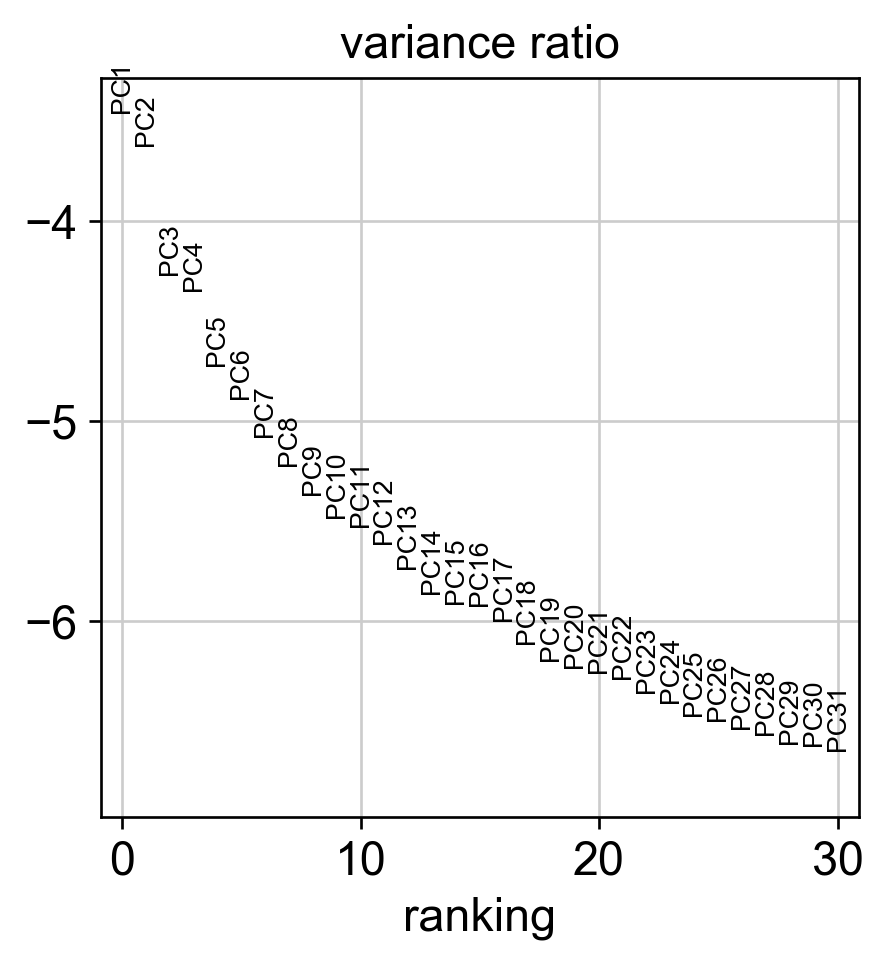

In [23]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [25]:
# run umap
sc.tl.umap(adata) 

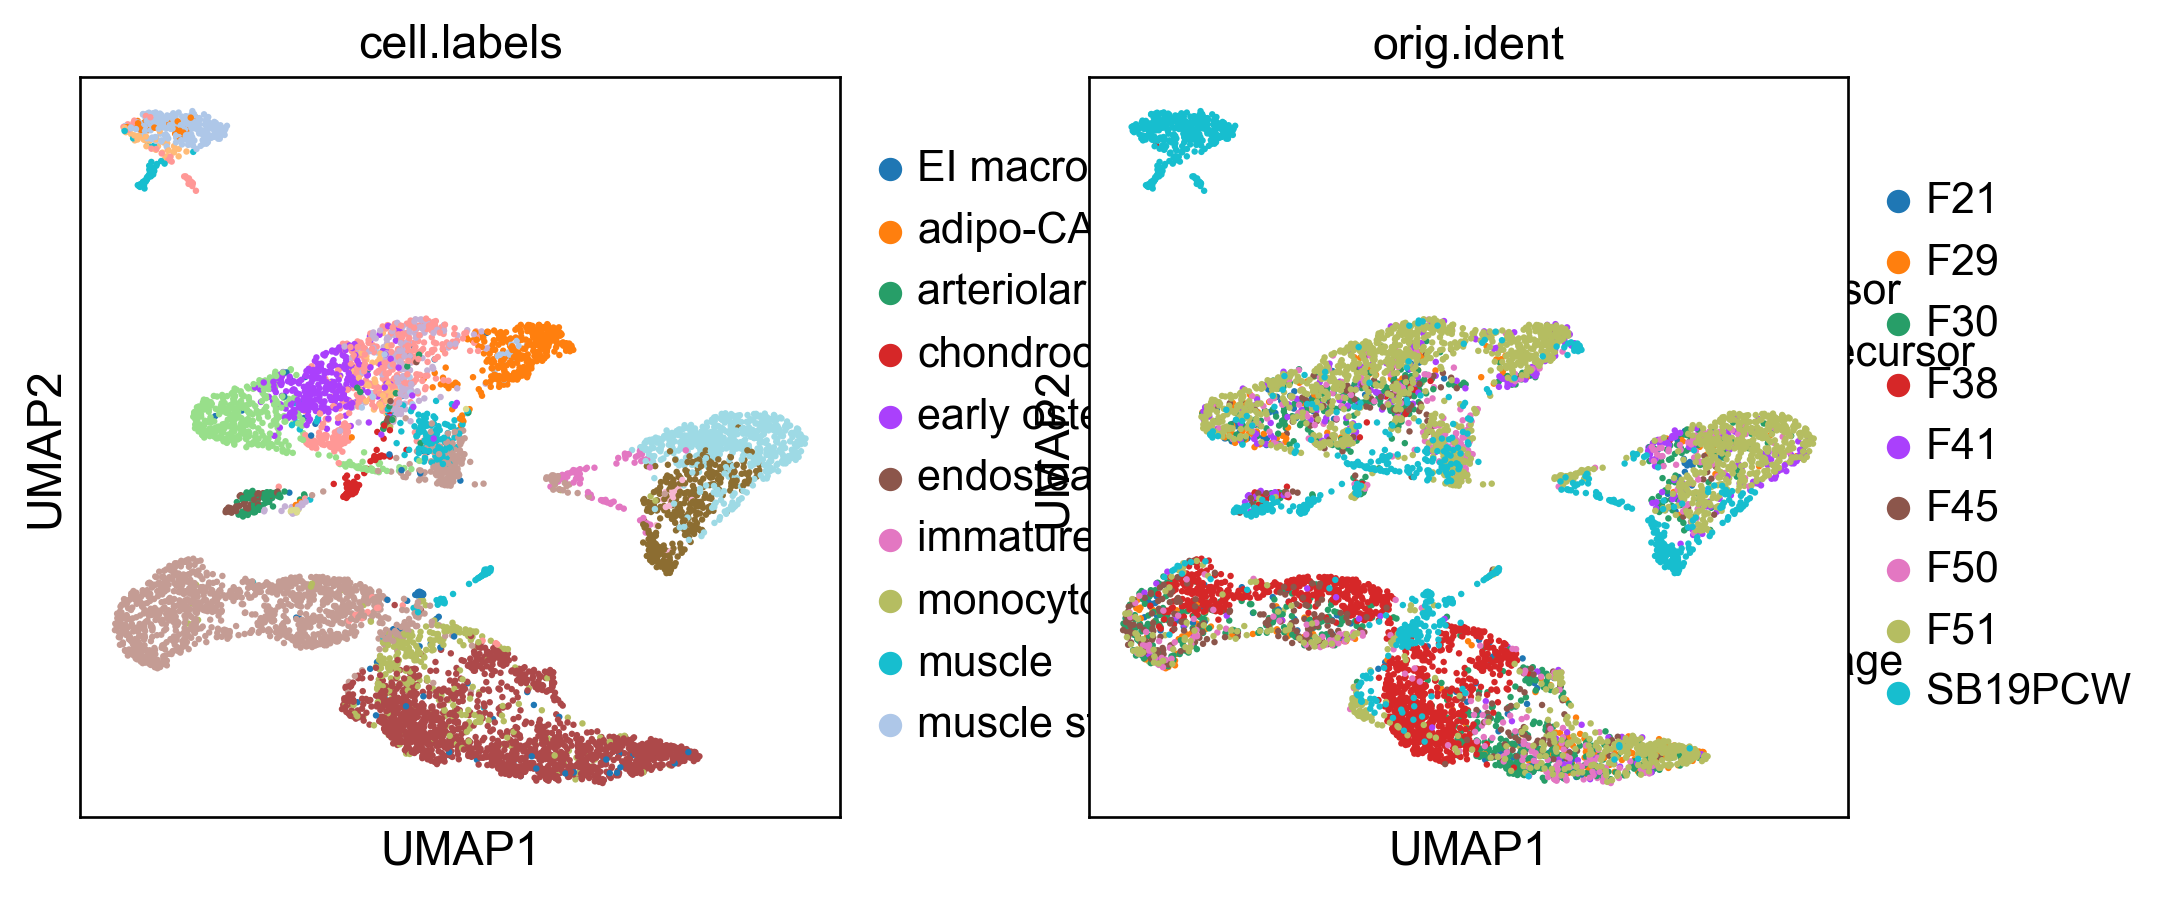

In [26]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [27]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [28]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [29]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [30]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

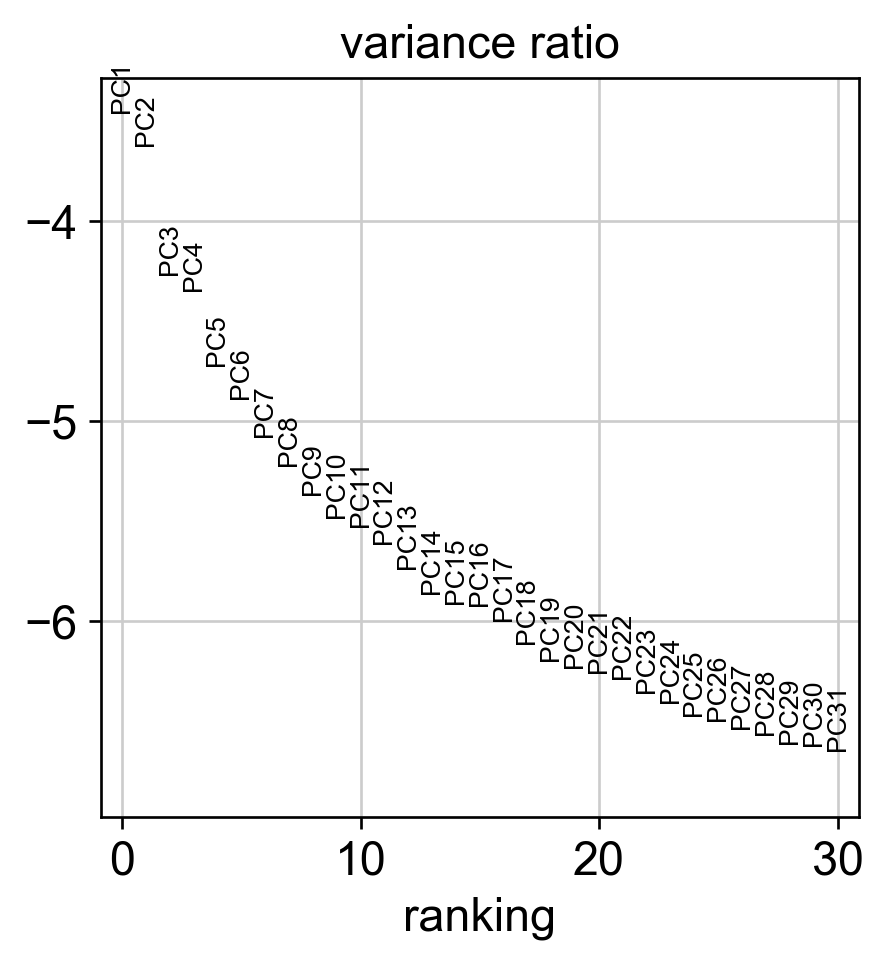

In [31]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [32]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [33]:
# run umap
sc.tl.umap(adata)

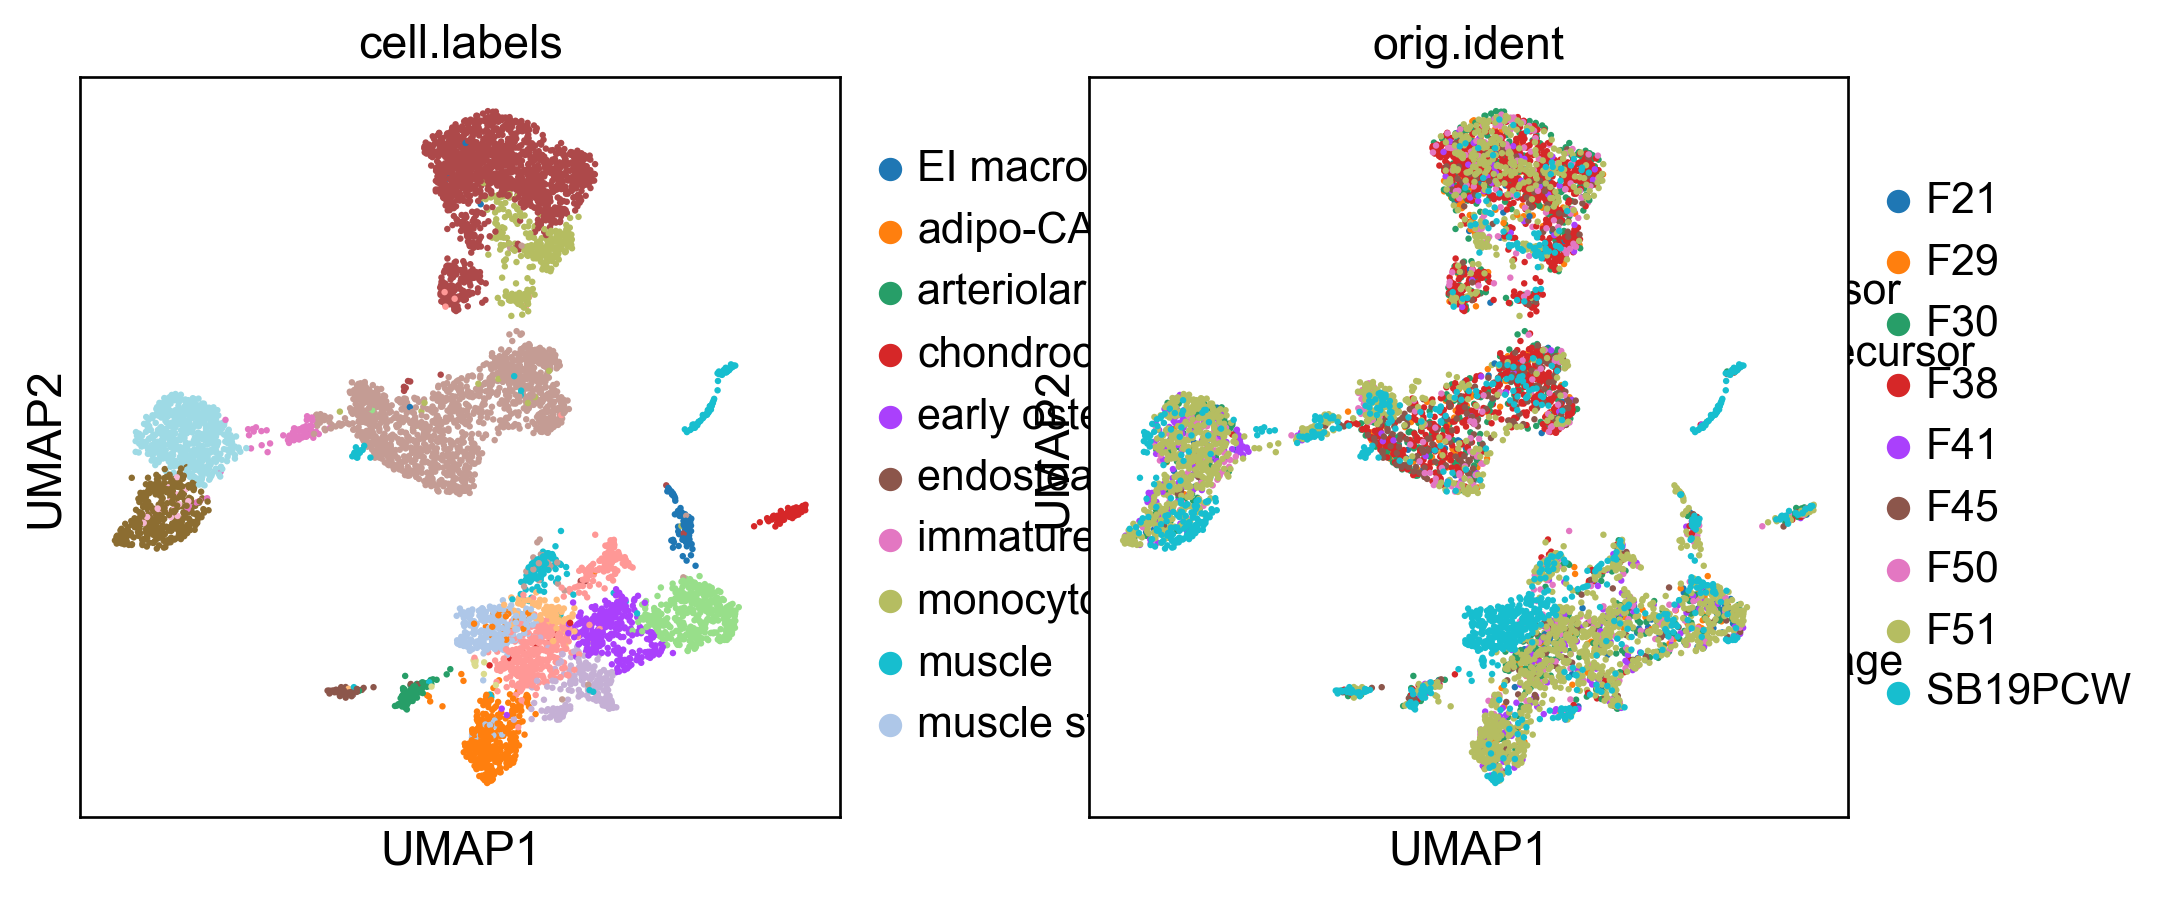

In [34]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

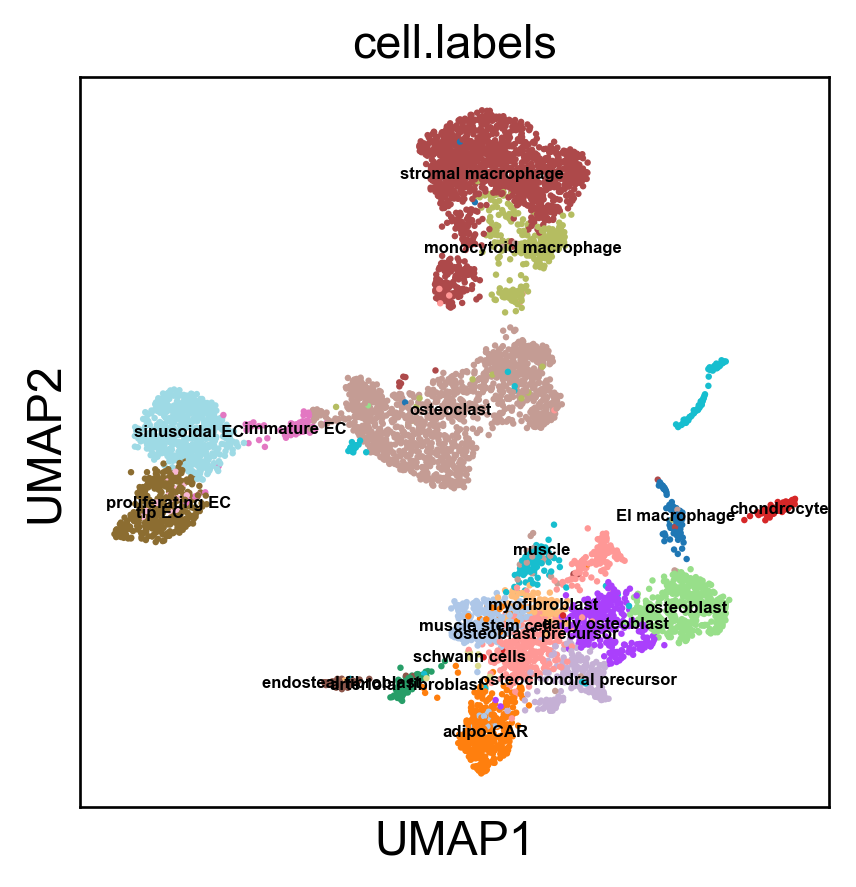

In [35]:
sc.pl.umap(adata, color=['cell.labels'], legend_loc="on data", size=15, legend_fontsize=5) 

# Change the colours for the myeloid lineage

In [36]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['EI macrophage', 'adipo-CAR', 'arteriolar fibroblast', 'chondrocyte', 'early osteoblast', 'endosteal fibroblast', 'immature EC', 'monocytoid macrophage', 'muscle', 'muscle stem cell', 'myofibroblast', 'osteoblast', 'osteoblast precursor', 'osteochondral precursor', 'osteoclast', 'proliferating EC', 'schwann cells', 'sinusoidal EC', 'stromal macrophage', 'tip EC'], dtype='object')

In [37]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['adipo-CAR', 
                    'arteriolar fibroblast', 'tip EC', 'stromal macrophage', 'sinusoidal EC', 'schwann cells',
                     'proliferating EC', 'osteoclast', 'osteochondral precursor', 'osteoblast precursor',                                        
                     'osteoblast', 'myofibroblast', 'muscle stem cell', 'muscle', 'monocytoid macrophage',  
                     'EI macrophage', 'immature EC', 'endosteal fibroblast', 'early osteoblast', 'chondrocyte'])

In [38]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'arteriolar fibroblast', 'tip EC', 'stromal macrophage', 'sinusoidal EC', 'schwann cells', 'proliferating EC', 'osteoclast', 'osteochondral precursor', 'osteoblast precursor', 'osteoblast', 'myofibroblast', 'muscle stem cell', 'muscle', 'monocytoid macrophage', 'EI macrophage', 'immature EC', 'endosteal fibroblast', 'early osteoblast', 'chondrocyte'], dtype='object')

In [39]:
adata.obs["cell.labels"].cat.categories[2]

'tip EC'

In [40]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#C49573' # adipo-CAR
new_colors[[1]] = '#87288A' # arteriolar fibroblast
new_colors[[2]] = '#D1DB94' # tip EC       
new_colors[[3]] = '#86B3E0' # stromal macrophage          
new_colors[[4]] = '#F59771' # sinusoidal EC         
new_colors[[5]] = '#D43D6A' # schwann cells       
new_colors[[6]] = '#F9F06C' # proliferating EC    
new_colors[[7]] = '#F595AA' # osteoclast 
new_colors[[8]] = '#BB7784' # osteochondral precursor     
new_colors[[9]] = '#E89FC5' # osteoblast precursor          
new_colors[[10]] = '#AD83BB' # osteoblast          
new_colors[[11]] = '#A0D4D0' # myofibroblast    
new_colors[[12]] = '#DCADC0' # muscle stem cell           
new_colors[[13]] = '#EED8E9' # muscle    
new_colors[[14]] = '#1B4794' # monocytoid macrophage 
new_colors[[15]] = '#791315' # EI macrophage     
new_colors[[16]] = '#A0A0A0' # immature EC     
new_colors[[17]] = '#48B9B4' # endosteal fibroblast         
new_colors[[18]] = '#8E88A8' # early osteoblast   
new_colors[[19]] = '#196F8B' # chondrocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#C49573', '#87288A', '#D1DB94', '#86B3E0', '#F59771', '#D43D6A',
       '#F9F06C', '#F595AA', '#BB7784', '#E89FC5', '#AD83BB', '#A0D4D0',
       '#DCADC0', '#EED8E9', '#1B4794', '#791315', '#A0A0A0', '#48B9B4',
       '#8E88A8', '#196F8B'], dtype='<U7')

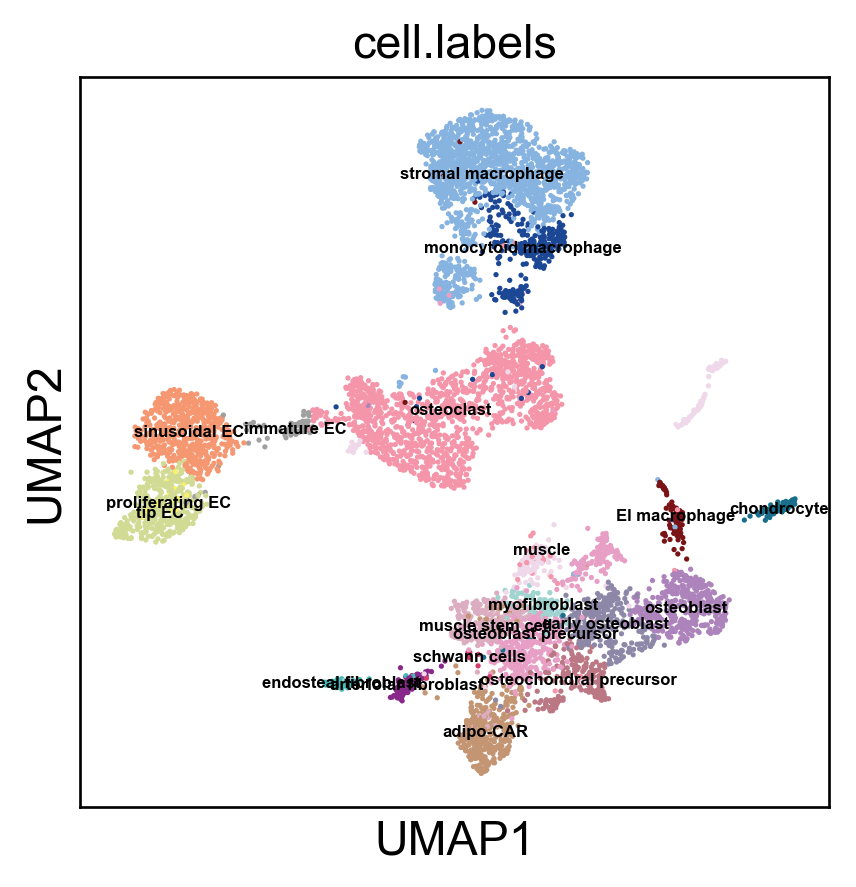

In [41]:
sc.pl.umap(adata, color=['cell.labels'], size=10, legend_loc="on data", legend_fontsize=5) 

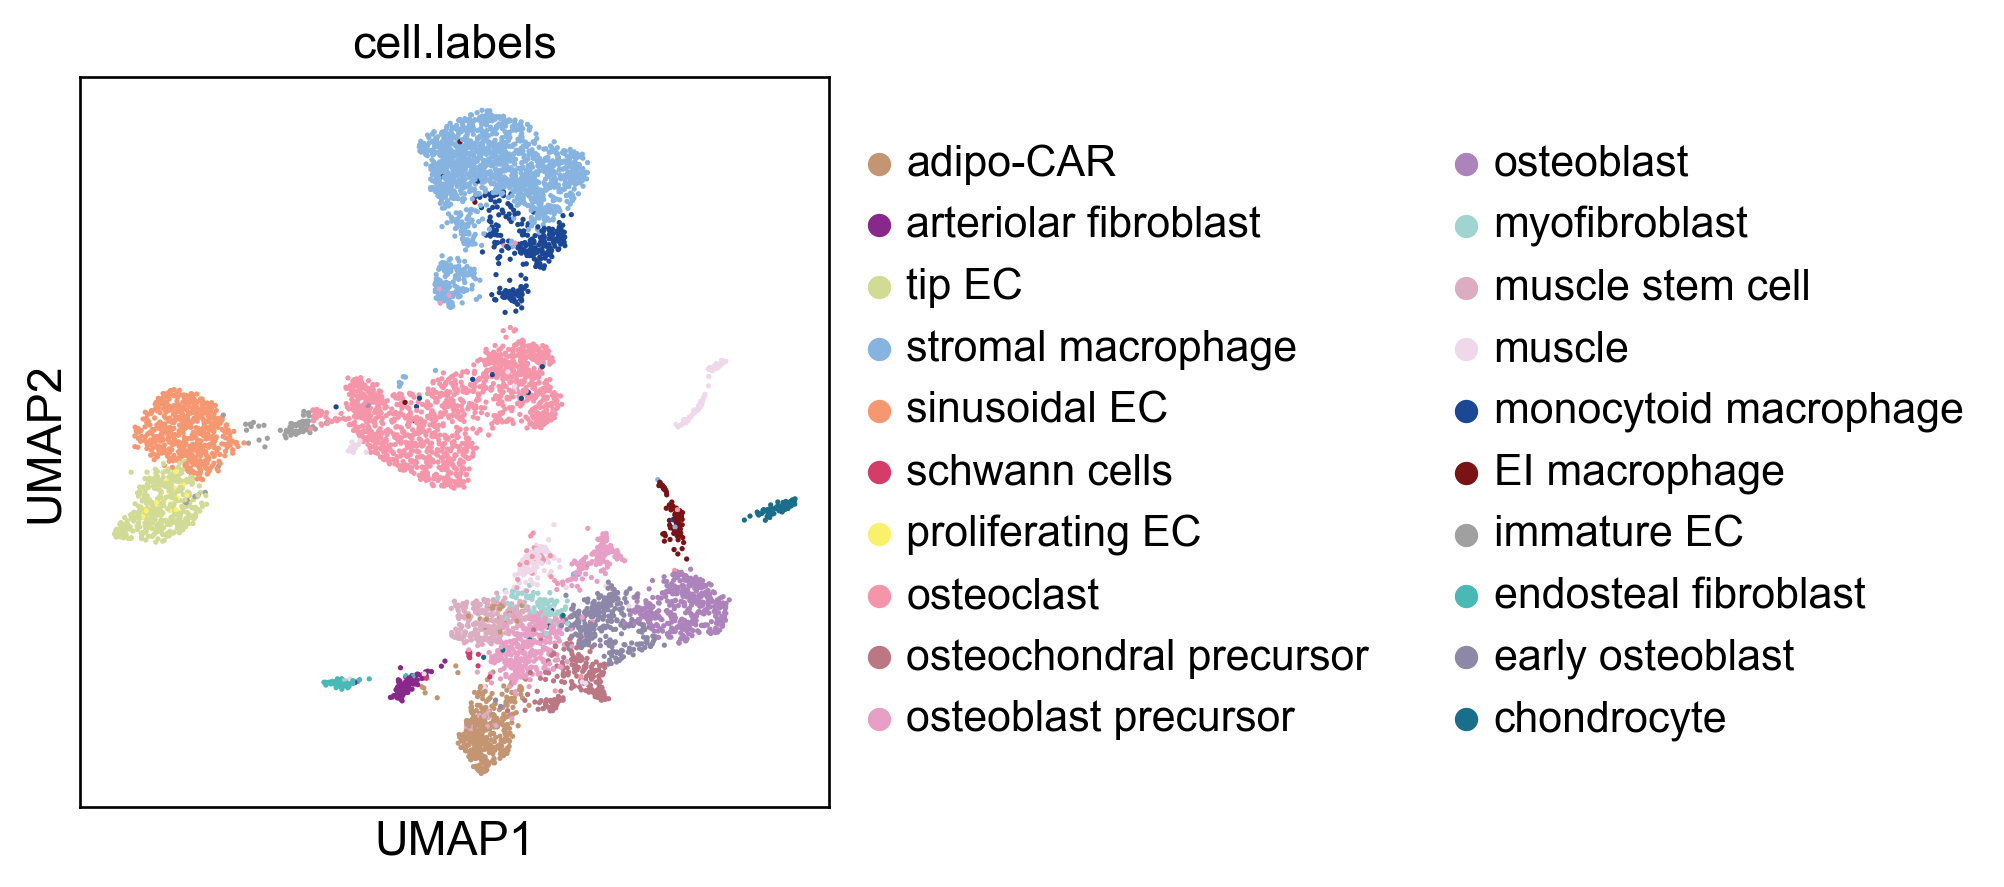

In [43]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=10, save="fig4a_stroma_umap_20200507.pdf") 

# Save the data

In [44]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [45]:
adata.X

<6726x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 16105547 stored elements in Compressed Sparse Row format>

In [46]:
adata.raw.X

<6726x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 17944923 stored elements in Compressed Sparse Row format>

In [47]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig4a_stroma_dr_20200507.h5ad")

# Re-run with better colours

# Import packages and data 

In [45]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [46]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [47]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig4a_stroma_dr_20200507.h5ad")

# Set the colours for the UMAP

# Change the colours for the myeloid lineage

In [48]:
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'arteriolar fibroblast', 'tip EC', 'stromal macrophage',
       'sinusoidal EC', 'schwann cells', 'proliferating EC', 'osteoclast',
       'osteochondral precursor', 'osteoblast precursor', 'osteoblast',
       'myofibroblast', 'muscle stem cell', 'muscle', 'monocytoid macrophage',
       'EI macrophage', 'immature EC', 'endosteal fibroblast',
       'early osteoblast', 'chondrocyte'],
      dtype='object')

In [49]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["muscle stem cell"], ["muscle"])

In [50]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['EI macrophage', 'adipo-CAR', 'arteriolar fibroblast', 'chondrocyte',
       'early osteoblast', 'endosteal fibroblast', 'immature EC',
       'monocytoid macrophage', 'muscle', 'myofibroblast', 'osteoblast',
       'osteoblast precursor', 'osteochondral precursor', 'osteoclast',
       'proliferating EC', 'schwann cells', 'sinusoidal EC',
       'stromal macrophage', 'tip EC'],
      dtype='object')

In [51]:
final_order = ['stromal macrophage',
'monocytoid macrophage',
'EI macrophage',
'osteoclast',
'immature EC',
'sinusoidal EC',
'proliferating EC',
'tip EC',
'endosteal fibroblast',
'arteriolar fibroblast',
'myofibroblast',
'muscle',
'schwann cells',
'osteochondral precursor',
'adipo-CAR',
'osteoblast precursor',
'early osteoblast',
'osteoblast',
'chondrocyte']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

In [52]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['stromal macrophage', 'monocytoid macrophage', 'EI macrophage',
       'osteoclast', 'immature EC', 'sinusoidal EC', 'proliferating EC',
       'tip EC', 'endosteal fibroblast', 'arteriolar fibroblast',
       'myofibroblast', 'muscle', 'schwann cells', 'osteochondral precursor',
       'adipo-CAR', 'osteoblast precursor', 'early osteoblast', 'osteoblast',
       'chondrocyte'],
      dtype='object')

In [53]:
adata.obs["cell.labels"].cat.categories[2]

'EI macrophage'

In [57]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#1B6633' # stromal macrophage
new_colors[[1]] = '#D1DB94' # monocytoid macrophage
new_colors[[2]] = '#87AC3F' # EI macrophage
new_colors[[3]] = '#F59771' # osteoclast
new_colors[[4]] = '#196F8B' # immature EC
new_colors[[5]] = '#F9F06C' # sinusoidal EC
new_colors[[6]] = '#9E6B49' # proliferating EC
new_colors[[7]] = '#E6DEC1' # tip EC
new_colors[[8]] = '#F3C3DB' # endosteal fibroblast
new_colors[[9]] = '#64C5E4' # arteriolar fibroblast
new_colors[[10]] = '#AD83BB' # myofibroblast
new_colors[[11]] = '#bebebe' # muscle
new_colors[[12]] = '#48B9B4' # schwann cells
new_colors[[13]] = '#D43D6A' # osteochondral precursor
new_colors[[14]] = '#F3C19F' # adipo-CAR
new_colors[[15]] = '#8E88A8' # osteoblast precursor
new_colors[[16]] = '#86B3E0' # early osteoblast
new_colors[[17]] = '#3B50A2' # osteoblast
new_colors[[18]] = '#A9479A' # chondrocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#1B6633', '#D1DB94', '#87AC3F', '#F59771', '#196F8B', '#F9F06C',
       '#9E6B49', '#E6DEC1', '#F3C3DB', '#64C5E4', '#AD83BB', '#bebebe',
       '#48B9B4', '#D43D6A', '#F3C19F', '#8E88A8', '#86B3E0', '#3B50A2',
       '#A9479A', '#196F8B'], dtype='<U7')

# Run UMAPs

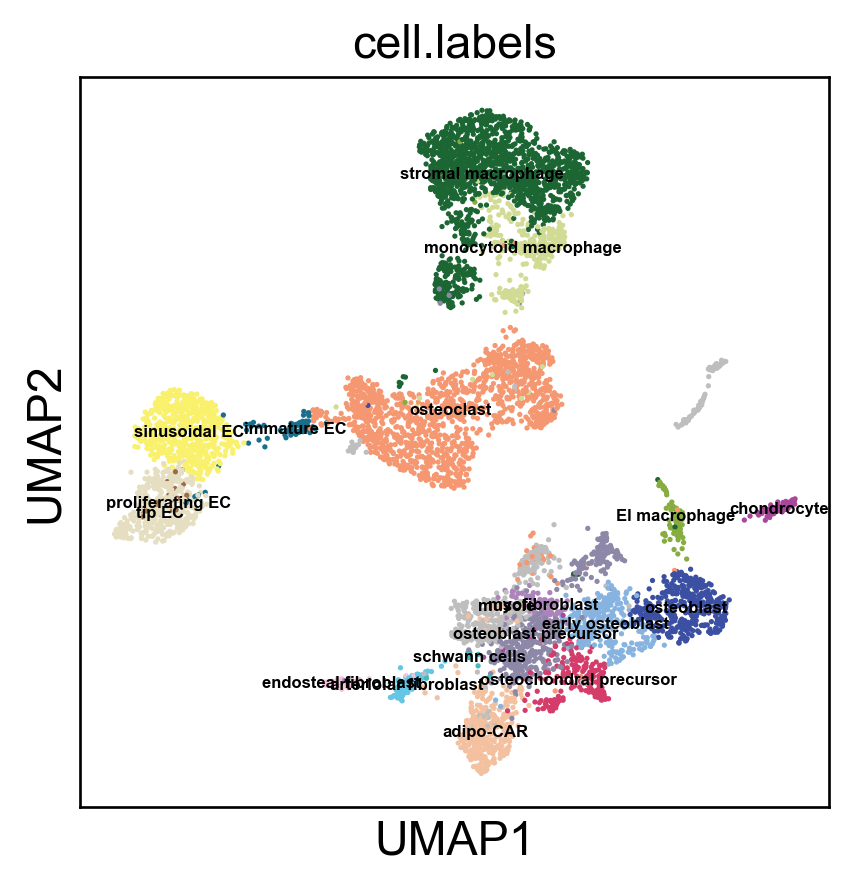

In [58]:
sc.pl.umap(adata, color=['cell.labels'], size=10, legend_loc="on data", legend_fontsize=5) 

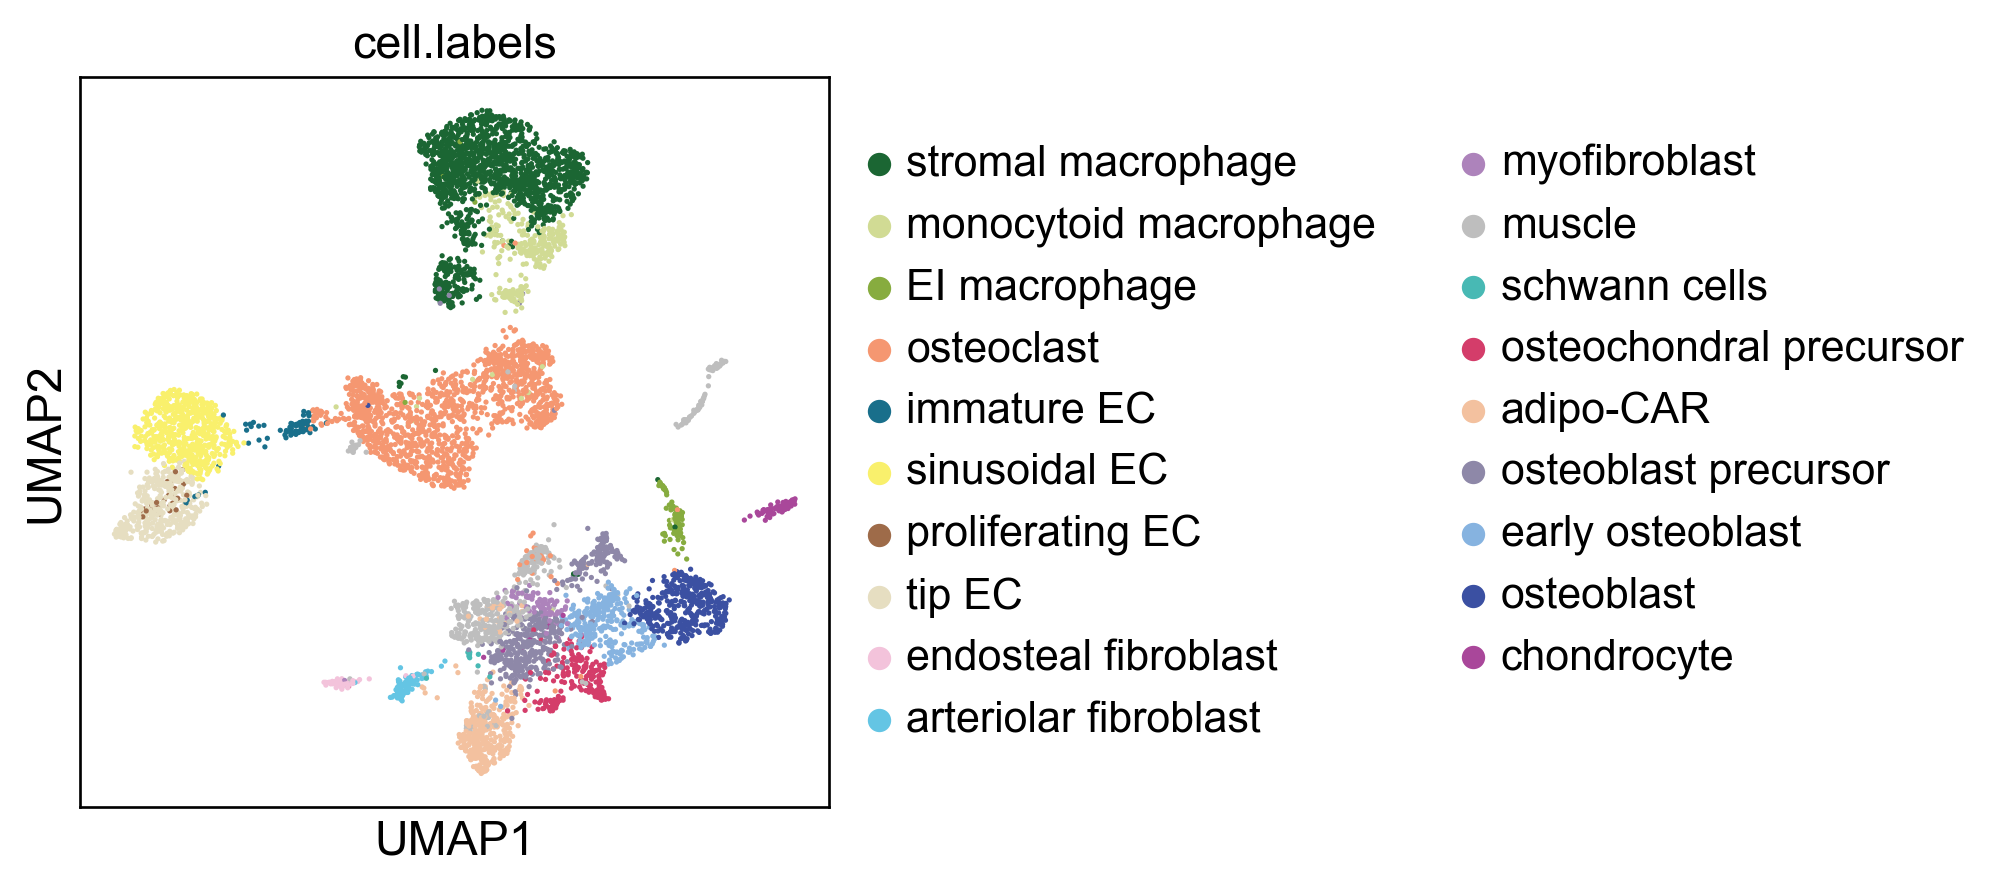

In [59]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=10, save="fig4a_umap_stroma_20200511.pdf") 

# Get cell numbers

In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [11]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [13]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig4a_stroma_dr_20200507.h5ad")

In [14]:
cell_numbers = adata.obs.groupby(["fetal.ids", "cell.labels"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/stroma_nrs_by_fetal_ids.csv")
cell_numbers

fetal.ids           cell.labels            
F21_male_16+2PCW    adipo-CAR                    3
                    tip EC                       7
                    stromal macrophage          39
                    sinusoidal EC               12
                    proliferating EC             1
                    osteoclast                  41
                    osteochondral precursor      8
                    osteoblast precursor        16
                    osteoblast                  24
                    myofibroblast                1
                    monocytoid macrophage        7
                    EI macrophage                6
                    early osteoblast            13
                    chondrocyte                  1
F29_female_17+0PCW  adipo-CAR                   16
                    tip EC                       2
                    stromal macrophage          85
                    sinusoidal EC               17
                    proliferating EC  